In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [2]:
#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split
# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [8]:
normalizeddataframe=pd.read_csv('forcetorquebuttonresults_10_04_2021.csv')#.head()
originaldataframe=normalizeddataframe

In [12]:
print(normalizeddataframe.shape)
print(normalizeddataframe)


(4764, 30)
       header0   header1   header2   header3   header4   header5   header6  \
0    -0.068855 -0.044869 -0.060737 -0.075361 -0.049069 -0.019544 -0.066683   
1     0.083175  0.155638  0.126217  0.112803  0.075403  0.100354  0.084586   
2     0.078092  0.086802  0.076653  0.074929  0.075920  0.069810  0.099747   
3    -0.029845 -0.042764 -0.039745 -0.038515 -0.031443 -0.039363 -0.033070   
4    -0.010229 -0.003806 -0.011523 -0.018237 -0.005753 -0.001511 -0.012752   
...        ...       ...       ...       ...       ...       ...       ...   
4759 -0.144416 -0.442895 -0.450188 -0.467356 -0.538750 -0.676004 -0.958254   
4760  0.207471 -0.304285 -0.146263 -0.361858 -0.225798 -1.211925 -1.467426   
4761  0.098536  0.378223  0.397413  0.427082  0.507462  0.571873  0.792655   
4762  0.171117  0.520219  0.552286  0.655644  0.889633  1.264238  1.244124   
4763  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

       header7   header8   header9  ...  header20  h

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [10]:
#Un Normalize data

xforcemin=-10
xforcemax=10
yforcemin=-10
yforcemax=10

zforcemin=-15
zforcemax=10
rolltorquemin=-2
rolltorquemax=2
pitchtorquemin=-2
pitchtorquemax=2
yawtorquemin=-.1
yawtorquemax=.1

xforce_normalized=-0.014937

xforce_original=(((xforce_normalized+1)/2)*(xforcemax-xforcemin)+xforcemin)
print(xforce_original)
xforce_normalized2=((xforce_original-xforcemin)/(xforcemax-xforcemin)*2)-1

print(xforce_normalized2)

-0.14936999999999934
-0.014936999999999978


In [17]:
a=4764/6
print(a)

794.0


In [18]:
normalizeddataframe=pd.read_csv('forcetorquebuttonresults_10_04_2021.csv')#.head()
originaldataframe=normalizeddataframe
#unnormalizerange=range(0,5,575)
#print(unnormalizerange)

for i in range(0,795,6):
  
    originaldataframe.iloc[i]=(((normalizeddataframe.iloc[i]+1)/2)*(xforcemax-xforcemin)+xforcemin)
    originaldataframe.iloc[i+1]=(((normalizeddataframe.iloc[i+1]+1)/2)*(yforcemax-yforcemin)+yforcemin)
    originaldataframe.iloc[i+2]=(((normalizeddataframe.iloc[i+2]+1)/2)*(zforcemax-zforcemin)+zforcemin)
    originaldataframe.iloc[i+3]=(((normalizeddataframe.iloc[i+3]+1)/2)*(rolltorquemax-rolltorquemin)+rolltorquemin)
    originaldataframe.iloc[i+4]=(((normalizeddataframe.iloc[i+4]+1)/2)*(pitchtorquemax-pitchtorquemin)+pitchtorquemin)
    

originaldataframe
originaldataframe.to_csv('forcetorquebuttonresults_unnormalized_10_04_2021.csv', index=False)  
print("data output to file")


data output to file


In [20]:
#Find new min and max values for each set of data

originaldataframe=pd.read_csv('forcetorquebuttonresults_unnormalized_10_04_2021.csv')#.head()
print(originaldataframe.shape)
xforcemin=999
xforcemax=-999
yforcemin=999
yforcemax=-999
zforcemin=999
zforcemax=-999
rolltorquemin=999
rolltorquemax=-999
pitchtorquemin=999
pitchtorquemax=-999


for i in range(0,575,6):
    xtempmin=originaldataframe.iloc[i].min(axis=0)
    xtempmax=originaldataframe.iloc[i].max(axis=0)
    ytempmin=originaldataframe.iloc[i+1].min(axis=0)
    ytempmax=originaldataframe.iloc[i+1].max(axis=0)
    ztempmin=originaldataframe.iloc[i+2].min(axis=0)
    ztempmax=originaldataframe.iloc[i+2].max(axis=0)
    rolltempmin=originaldataframe.iloc[i+3].min(axis=0)
    rolltempmax=originaldataframe.iloc[i+3].max(axis=0)
    pitchtempmin=originaldataframe.iloc[i+4].min(axis=0)
    pitchtempmax=originaldataframe.iloc[i+4].max(axis=0)
    
    if xtempmin<xforcemin:
        xforcemin=xtempmin
    if ytempmin<yforcemin:
        yforcemin=ytempmin
    if ztempmin<zforcemin:
        zforcemin=ztempmin
        #print("row",i+2,"new min =",zforcemin)
    #if ztempmin<-50:
        #print("row",i+2,"low z =",zforcemin)
        
    if rolltempmin<rolltorquemin:
        rolltorquemin=rolltempmin
   
        
    if xtempmax>xforcemax:
        xforcemax=xtempmax
    if ytempmax>yforcemax:
        yforcemax=ytempmax
    if ztempmax>zforcemax:
        zforcemax=ztempmax
        #print("new max=",zforcemax)
    if rolltempmax>rolltorquemax:
        rolltorquemax=rolltempmax

    if pitchtempmin<pitchtorquemin:
        pitchtorquemin=pitchtempmin    
        
    if pitchtempmax>pitchtorquemax:
        pitchtorquemax=pitchtempmax   
   
 
    
print("xforcemin=",xforcemin,"xforcemax=",xforcemax)
print("yforcemin=",yforcemin,"yforcemax=",yforcemax)
print("zforcemin=",zforcemin,"zforcemax=",zforcemax)
print("rolltorquemin=",rolltorquemin,"rolltorquemax=",rolltorquemax)
print("pitchtorquemin=",pitchtorquemin,"pitchtorquemax=",pitchtorquemax)






(4764, 30)
xforcemin= -47.44705974939552 xforcemax= 43.25664007930645
yforcemin= -85.6046291498482 yforcemax= 83.31844701378286
zforcemin= -135.31193455377723 zforcemax= -8.138808388443245
rolltorquemin= -11.993303627339632 rolltorquemax= 12.234356901329193
pitchtorquemin= -14.201129403557673 pitchtorquemax= 13.41306238100583


In [26]:
originaldataframe=pd.read_csv('forcetorquebuttonresults_unnormalized_10_04_2021.csv')#.head()
#Create quantile transformers

xforcearray=np.array([])
#print(xforcearray)

temparray=pd.DataFrame(originaldataframe.iloc[0]).to_numpy()
temparray=temparray.T.flatten()
#print(temparray)
#print(temparray)

#print(temparray[0])
#xforcearray=temparray

print(temparray)
print("xforcearray",xforcearray)
print(xforcearray.shape)

xforcearray=np.append(xforcearray,temparray)
print(xforcearray)
print(xforcearray.shape)

[-2.13580609 -1.62501489 -1.96292695 -2.27435977 -1.71444458 -1.08568324
 -2.08955734 -2.46441344 -1.71952682 -2.25193258 -2.16704046 -1.10043617
 -1.7972183  -1.70087116  1.07284313  3.85918658  1.61955377 11.21871584
  8.48336554  6.77072468 -3.60504638 -4.06777907 -3.83631587 -3.35808455
 -3.79535659 -0.7046921  -3.40109483 -0.37376795 -3.35653875 -3.38036297]
xforcearray []
(0,)
[-2.13580609 -1.62501489 -1.96292695 -2.27435977 -1.71444458 -1.08568324
 -2.08955734 -2.46441344 -1.71952682 -2.25193258 -2.16704046 -1.10043617
 -1.7972183  -1.70087116  1.07284313  3.85918658  1.61955377 11.21871584
  8.48336554  6.77072468 -3.60504638 -4.06777907 -3.83631587 -3.35808455
 -3.79535659 -0.7046921  -3.40109483 -0.37376795 -3.35653875 -3.38036297]
(30,)


In [33]:
originaldataframe=pd.read_csv('forcetorquebuttonresults_unnormalized_10_04_2021.csv')#.head()

xforcearray=np.array([])
yforcearray=np.array([])
zforcearray=np.array([])
rolltorquearray=np.array([])
pitchtorquearray=np.array([])



for i in range(0,4764,6):
    
    x_temparray=pd.DataFrame(originaldataframe.iloc[i]).to_numpy()
    y_temparray=pd.DataFrame(originaldataframe.iloc[i+1]).to_numpy()
    z_temparray=pd.DataFrame(originaldataframe.iloc[i+2]).to_numpy()
    roll_temparray=pd.DataFrame(originaldataframe.iloc[i+3]).to_numpy()
    pitch_temparray=pd.DataFrame(originaldataframe.iloc[i+4]).to_numpy()
    
    xforcearray=np.append(xforcearray,x_temparray.T.flatten())
    yforcearray=np.append(yforcearray,y_temparray.T.flatten())
    zforcearray=np.append(zforcearray,z_temparray.T.flatten())
    rolltorquearray=np.append(rolltorquearray,roll_temparray.T.flatten())
    pitchtorquearray=np.append(pitchtorquearray,pitch_temparray.T.flatten())

print(xforcearray.shape)
print(yforcearray.shape)
print(zforcearray.shape)
print(rolltorquearray.shape)
print(pitchtorquearray.shape)
print(xforcearray[0:10])

(23820,)
(23820,)
(23820,)
(23820,)
(23820,)
[-2.13580609 -1.62501489 -1.96292695 -2.27435977 -1.71444458 -1.08568324
 -2.08955734 -2.46441344 -1.71952682 -2.25193258]


## Fit transformers

In [34]:
#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#results

xforcearray=np.sort(xforcearray)
#xforcearray_transformer = QuantileTransformer(n_quantiles=4, random_state=0)
xforcearray_transformer =MinMaxScaler()
xforcearray=xforcearray.reshape(-1, 1)
xforcearray_transformer.fit(xforcearray)
x_transformed=xforcearray_transformer.transform(xforcearray)

yforcearray=np.sort(yforcearray)
#xforcearray_transformer = QuantileTransformer(n_quantiles=4, random_state=0)
yforcearray_transformer =MinMaxScaler()
yforcearray=yforcearray.reshape(-1, 1)
yforcearray_transformer.fit(yforcearray)
y_transformed=yforcearray_transformer.transform(yforcearray)

zforcearray=np.sort(zforcearray)
#xforcearray_transformer = QuantileTransformer(n_quantiles=4, random_state=0)
zforcearray_transformer =MinMaxScaler()
zforcearray=zforcearray.reshape(-1, 1)
zforcearray_transformer.fit(zforcearray)
z_transformed=zforcearray_transformer.transform(zforcearray)

rolltorquearray=np.sort(rolltorquearray)
#xforcearray_transformer = QuantileTransformer(n_quantiles=4, random_state=0)
rolltorquearray_transformer =MinMaxScaler()
rolltorquearray=rolltorquearray.reshape(-1, 1)
rolltorquearray_transformer.fit(rolltorquearray)
roll_transformed=rolltorquearray_transformer.transform(rolltorquearray)

pitchtorquearray=np.sort(pitchtorquearray)
#pitchtorquearray_transformer= QuantileTransformer(n_quantiles=4, random_state=0)
pitchtorquearray_transformer =MinMaxScaler()
pitchtorquearray=pitchtorquearray.reshape(-1, 1)
pitchtorquearray_transformer.fit(pitchtorquearray)
pitch_transformed=pitchtorquearray_transformer.transform(pitchtorquearray)

print("fit complete")

fit complete


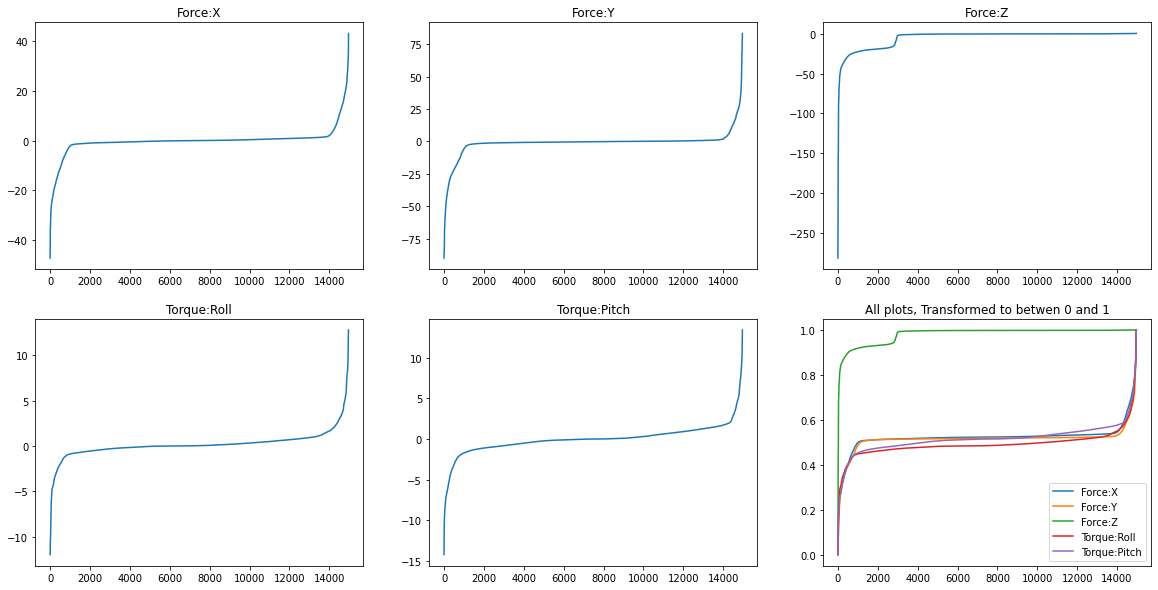

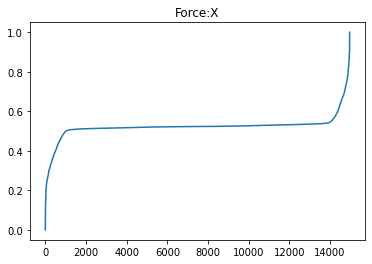

In [35]:
fig = plt.figure(figsize=(20, 10)) #figsize=(25, 80)
ax1 = plt.subplot(2, 3, 1)
ax1.plot(xforcearray)
plt.title("Force:X")
ax2 = plt.subplot(2, 3, 2)
ax2.plot(yforcearray)
plt.title("Force:Y")
ax3 = plt.subplot(2, 3, 3)
ax3.plot(zforcearray)
plt.title("Force:Z")
ax4 = plt.subplot(2, 3, 4)
ax4.plot(rolltorquearray)
plt.title("Torque:Roll")
ax5 = plt.subplot(2, 3, 5)
ax5.plot(pitchtorquearray)
plt.title("Torque:Pitch")
ax6 = plt.subplot(2, 3, 6)    
ax6.plot(x_transformed, label="Force:X")
ax6.plot(y_transformed, label="Force:Y")
ax6.plot(z_transformed, label="Force:Z")
ax6.plot(roll_transformed, label="Torque:Roll")
ax6.plot(pitch_transformed, label="Torque:Pitch")
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles, labels,loc='lower right')

plt.title("All plots, Transformed to betwen 0 and 1")
plt.show()


plt.plot(x_transformed, label="Force:X")
plt.title("Force:X")
plt.show()

## Generate normalized data according to transformers. 

In [44]:

print(originaldataframe.shape)
print(originaldataframe.shape[0]/6)  #795 total episodes. Galues go from 0 to 794
print(int((originaldataframe.shape[0]/6)+1))

(4764, 30)
794.0
795


In [45]:
originaldataframe=pd.read_csv('forcetorquebuttonresults_unnormalized_10_04_2021.csv')#.head()

transformeddataframe=originaldataframe
headers=[]
for i in range(30):
    label=str(i)
    headers.append("header"+label)

#for i in range(0,575,6):
for i in range(0,int((originaldataframe.shape[0]/6)+1),6):
   # transformeddataframe.iloc[i]=xforcearray_transformer.transform(originaldataframe.iloc[i])
   
    x_temparray=pd.DataFrame(originaldataframe.iloc[i]).to_numpy()
    #print(x_temparray)
    x_temparray=x_temparray.T
    #print(x_temparray)
    x_temparraytransformed=xforcearray_transformer.transform(x_temparray)
    #print("x_temparraytransformed",x_temparraytransformed[0])
    transformeddataframe.iloc[i]= x_temparraytransformed[0]
    #print(transformeddataframe.iloc[i])
    
    y_temparray=pd.DataFrame(originaldataframe.iloc[i+1]).to_numpy()
    y_temparray=y_temparray.T
    y_temparraytransformed=yforcearray_transformer.transform(y_temparray)
    transformeddataframe.iloc[i+1]= y_temparraytransformed[0]
    
    z_temparray=pd.DataFrame(originaldataframe.iloc[i+2]).to_numpy()
    z_temparray=z_temparray.T
    z_temparraytransformed=zforcearray_transformer.transform(z_temparray)
    transformeddataframe.iloc[i+2]= z_temparraytransformed[0]
    
    roll_temparray=pd.DataFrame(originaldataframe.iloc[i+3]).to_numpy()
    roll_temparray=roll_temparray.T
    roll_temparraytransformed=rolltorquearray_transformer.transform(roll_temparray)
    transformeddataframe.iloc[i+3]= roll_temparraytransformed[0]
    
    pitch_temparray=pd.DataFrame(originaldataframe.iloc[i+4]).to_numpy()
    pitch_temparray=pitch_temparray.T
    pitch_temparraytransformed=pitchtorquearray_transformer.transform(pitch_temparray)
    transformeddataframe.iloc[i+4]= pitch_temparraytransformed[0]
    
#uncomment below to update file
transformeddataframe.to_csv('forcetorquebuttonresults_renormalized_10_04_2021.csv', index=False)  
print("data output to file complete") 

data output to file complete


## Cutting data to final 10 timesteps of every episode

In [3]:

choppedheaders=[]
for i in range(10):
    label=str(i)
    choppedheaders.append("header"+label)

headers=[]
for i in range(30):
    label=str(i)
    headers.append("header"+label)
    
normalizeddata=pd.read_csv('forcetorquebuttonresults_renormalized_10_04_2021.csv')#.head()
choppeddata= pd.DataFrame(columns=choppedheaders)
print(choppeddata)


Empty DataFrame
Columns: [header0, header1, header2, header3, header4, header5, header6, header7, header8, header9]
Index: []


In [48]:
h=11
i=570

choppedheaders=[]
for i in range(10):
    label=str(i)
    choppedheaders.append("header"+label)
    
    
a=normalizeddata[headers[(h-9):h+1]].iloc[i+5]
a=a.tolist()
print(a)

df = pd.DataFrame(columns=choppedheaders)
#print("choppedheaders",choppedheaders)
#print(choppedheaders.type())
df.loc[len(df)]=a
df.loc[len(df)]=a
print(df)
  
# append rows to an empty DataFrame
#df = df.append({'Name' : 'Ankit', 'Articles' : 97, 'Improved' : 2200}, 
#                ignore_index = True)

[0.9320387053945564, 0.9282097718417166, 0.9289430937458234, 0.927668759320267, 0.9288175326242226, 0.9316630441428084, 0.9303023581597668, 0.9301425574393516, 0.928305892304143, 0.9277495585457108]
    header0  header1   header2   header3   header4   header5   header6  \
0  0.932039  0.92821  0.928943  0.927669  0.928818  0.931663  0.930302   
1  0.932039  0.92821  0.928943  0.927669  0.928818  0.931663  0.930302   

    header7   header8  header9  
0  0.930143  0.928306  0.92775  
1  0.930143  0.928306  0.92775  


In [51]:
int((normalizeddata.shape[0])+1)

4765

In [53]:

choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

choppeddata = pd.DataFrame(columns=choppedheaders)


for i in range(0,int((normalizeddata.shape[0])-1),6):
    #print("")
    for h in range(len(headers)):
        successflag=False
        if normalizeddata[headers[h]].iloc[i+5]==1:
            tempdata0=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i]).tolist()
            tempdata1=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+1]).tolist()
            tempdata2=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+2]).tolist()
            tempdata3=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+3]).tolist()
            tempdata4=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+4]).tolist()
            tempdata5=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+5]).tolist()
            
            #tempdata=tempdata.tolist()
            choppeddata.loc[len(choppeddata)]=tempdata0 #add list of data to new row in dataframe
            choppeddata.loc[len(choppeddata)]=tempdata1 
            choppeddata.loc[len(choppeddata)]=tempdata2 
            choppeddata.loc[len(choppeddata)]=tempdata3 
            choppeddata.loc[len(choppeddata)]=tempdata4 
            choppeddata.loc[len(choppeddata)]=tempdata5 
            successflag=True
            break
          
    if successflag==False:
        # if run was not successful, grab the last 11 timesteps from the run. I may need to sample more?
        tempdata0=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i]).tolist()
        tempdata1=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+1]).tolist()
        tempdata2=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+2]).tolist()
        tempdata3=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+3]).tolist()
        tempdata4=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+4]).tolist()
        tempdata5=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+5]).tolist()
        choppeddata.loc[len(choppeddata)]=tempdata0 #add list of data to new row in dataframe
        choppeddata.loc[len(choppeddata)]=tempdata1 
        choppeddata.loc[len(choppeddata)]=tempdata2 
        choppeddata.loc[len(choppeddata)]=tempdata3 
        choppeddata.loc[len(choppeddata)]=tempdata4 
        choppeddata.loc[len(choppeddata)]=tempdata5 

            
            
            #print("col:",headers[(h-11):h],"row:", i+5)
            #print("values:",normalizeddata[headers[(h-11):h+1]].iloc[i+5])
            
            
            
            
choppeddata.to_csv('choppeddata_10_04_2021.csv', index=False)  
print("data output to file complete")          

data output to file complete


## Output data set with equal quantities of successful and failed runs.

In [7]:
print(normalizeddata.shape)
print(normalizeddata.shape[0]/6)

(4764, 30)
794.0


In [10]:
headers=[]
for i in range(30):
    label=str(i)
    headers.append("header"+label)
    
choppedheaders=[]
for i in range(10):
    label=str(i)
    choppedheaders.append("header"+label)
    
normalizeddata=pd.read_csv('forcetorquebuttonresults_renormalized_10_04_2021.csv')#.head()

choppeddata = pd.DataFrame(columns=choppedheaders)
failcounter=0
successcounter=0
lookback=10

for i in range(0,int((normalizeddata.shape[0])-1),6):
    #print("")
    for h in range(len(headers)):
        successflag=False
        if normalizeddata[headers[h]].iloc[i+5]==1 and successcounter<120:
            tempdata0=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i]).tolist()
            tempdata1=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+1]).tolist()
            tempdata2=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+2]).tolist()
            tempdata3=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+3]).tolist()
            tempdata4=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+4]).tolist()
            tempdata5=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+5]).tolist()
            
            #tempdata=tempdata.tolist()
            choppeddata.loc[len(choppeddata)]=tempdata0 #add list of data to new row in dataframe
            choppeddata.loc[len(choppeddata)]=tempdata1 
            choppeddata.loc[len(choppeddata)]=tempdata2 
            choppeddata.loc[len(choppeddata)]=tempdata3 
            choppeddata.loc[len(choppeddata)]=tempdata4 
            choppeddata.loc[len(choppeddata)]=tempdata5 
            successflag=True
            successcounter+=1
            print("successcounter",successcounter)
            break
        elif normalizeddata[headers[h]].iloc[i+5]==1:
            successflag=True
            break
    if successflag==False:
        # if run was not successful, grab the last 11 timesteps from the run. I may need to sample more?
        tempdata0=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i]).tolist()
        tempdata1=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+1]).tolist()
        tempdata2=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+2]).tolist()
        tempdata3=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+3]).tolist()
        tempdata4=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+4]).tolist()
        tempdata5=(normalizeddata[headers[(len(headers)-(lookback)):(len(headers))]].iloc[i+5]).tolist()
        choppeddata.loc[len(choppeddata)]=tempdata0 #add list of data to new row in dataframe
        choppeddata.loc[len(choppeddata)]=tempdata1 
        choppeddata.loc[len(choppeddata)]=tempdata2 
        choppeddata.loc[len(choppeddata)]=tempdata3 
        choppeddata.loc[len(choppeddata)]=tempdata4 
        choppeddata.loc[len(choppeddata)]=tempdata5 

            
            
            #print("col:",headers[(h-11):h],"row:", i+5)
            #print("values:",normalizeddata[headers[(h-11):h+1]].iloc[i+5])
            
            
            
            
choppeddata.to_csv('choppeddata_10_04_2021_equalsuccessfail.csv', index=False)  
print("data output to file complete")          

successcounter 1
successcounter 2
successcounter 3
successcounter 4
successcounter 5
successcounter 6
successcounter 7
successcounter 8
successcounter 9
successcounter 10
successcounter 11
successcounter 12
successcounter 13
successcounter 14
successcounter 15
successcounter 16
successcounter 17
successcounter 18
successcounter 19
successcounter 20
successcounter 21
successcounter 22
successcounter 23
successcounter 24
successcounter 25
successcounter 26
successcounter 27
successcounter 28
successcounter 29
successcounter 30
successcounter 31
successcounter 32
successcounter 33
successcounter 34
successcounter 35
successcounter 36
successcounter 37
successcounter 38
successcounter 39
successcounter 40
successcounter 41
successcounter 42
successcounter 43
successcounter 44
successcounter 45
successcounter 46
successcounter 47
successcounter 48
successcounter 49
successcounter 50
successcounter 51
successcounter 52
successcounter 53
successcounter 54
successcounter 55
successcounter 56
s

In [11]:
equaldata=pd.read_csv('choppeddata_10_04_2021_equalsuccessfail.csv')#.head()
print(equaldata.shape)

(1440, 10)


In [12]:
print(equaldata.shape[0]/6)

240.0


In [8]:
choppeddata.shape

(4764, 10)